<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/Neuroscience/blurry_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/Neuroscience/blurry_vision.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Vision with Lost Glasses: Modelling how the brain deals with noisy input

**By Neuromatch Academy**

__Content creators:__ Rishika Mohanta, Furkan Özçelik, Salomey Osei

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>


---
# Objective

Imagine you lost your spectacle and the world around you is completely blurred out. As you stumble around, you see a small animal walk towards you. Can you figure out what it is? Probably yes right?

In this situation, or in foggy/night-time conditions, visual input is of poor quality; images are blurred and have low contrast and yet our brains manage to recognize it. Is it possible to model the process? Does previous experience help?

---
# Setup

In [ ]:
# @title Install dependencies
!pip install torch_intermediate_layer_getter --quiet
!pip install Pillow --quiet

In [ ]:
# Imports
import random
import time

import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from shutil import copyfile, rmtree
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
# For getting output of intermediate layers in Pytorch
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
# For interactive visualization
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms

%load_ext tensorboard

In [ ]:
# @title Helpers functions
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


**The Asirra dataset**

The CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof) challenge is the motivation behind the creation of this dataset.


Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately.

*Reference: Dataset can be found here* ([https://www.kaggle.com/c/dogs-vs-cats](https://www.kaggle.com/c/dogs-vs-cats]))

In [ ]:
# @title Download Cleaned Data

# @markdown This particular dataset is a cleaned and processed version of Kaggle's Dogs vs. Cats Competition. The Data is organised as three folders `dataset`, `dataset_blur_2`, `dataset_blur_5`.
# @markdown Each folder has a `train` and `test` subfolder and each subfolder has a `cat` and `dog` folder which contain the images.


# @markdown `dataset` contains the clear images

# @markdown `dataset_blur_2` contains the images with a Gaussian Blur (radius = 2)

# @markdown `dataset_blur_5` contains the images with a Gaussian Blur (radius = 5)

import os, zipfile, requests

filenames = ["catvdog_clear.zip",
             "catvdog_blur_2.zip",
             "catvdog_blur_5.zip"]

urls = ["https://osf.io/hj2gd/download",
        "https://osf.io/xp6qd/download",
        "https://osf.io/wj43a/download"]
for fname, url in zip(filenames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

for fname in filenames:
  zip_ref = zipfile.ZipFile(fname, 'r')
  zip_ref.extractall()
  zip_ref.close()
  os.remove(fname)

## Define preprocessing pipeline and dataloaders
Here we only load the dataset with clear images and gaussian blur with radius 5. You can explore the other by loading the appropriate folder.

In [ ]:
# Define Preprocessing Filters
preprocessing = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))])

# Create Clean Training Dataset using ImageFolder
clear_train_data = torchvision.datasets.ImageFolder(
    root="dataset/train",
    transform=preprocessing
)

# Create Clean Test Dataset using ImageFolder
clear_test_data = torchvision.datasets.ImageFolder(
    root="dataset/test",
    transform=preprocessing
)

# Create Noisy Training Dataset using ImageFolder
noisy_train_data = torchvision.datasets.ImageFolder(
    root="dataset_blur_5/train",
    transform=preprocessing
)

# Create Noisy Test Dataset using ImageFolder
noisy_test_data = torchvision.datasets.ImageFolder(
    root="dataset_blur_5/test",
    transform=preprocessing
)

# function to apply a training-validation set split on a dataset
def validation_split(train_data, val_ratio = 0.2):
  train_indices, val_indices, _, _ = train_test_split(range(len(train_data)),
                                                      train_data.targets,
                                                      stratify=train_data.targets,
                                                      test_size=val_ratio)
  train_split = torch.utils.data.Subset(train_data, train_indices)
  val_split = torch.utils.data.Subset(train_data, val_indices)
  return train_split,val_split

# Define Batch Size
batch_size = 128

# Define Dataloaders for Training, Validation and Test sets
clear_train_split,clear_val_split = validation_split(clear_train_data)
clear_train_batches = torch.utils.data.DataLoader(clear_train_split,
                                                  batch_size=batch_size,
                                                  shuffle=True)
clear_val_batches = torch.utils.data.DataLoader(clear_val_split,
                                                batch_size=batch_size,
                                                shuffle=True)
clear_test_batches = torch.utils.data.DataLoader(clear_test_data,
                                                 batch_size=batch_size,
                                                 shuffle=True)

noisy_train_split,noisy_val_split = validation_split(noisy_train_data)
noisy_train_batches = torch.utils.data.DataLoader(noisy_train_split,
                                                  batch_size=batch_size,
                                                  shuffle=True)
noisy_val_batches = torch.utils.data.DataLoader(noisy_val_split,
                                                batch_size=batch_size,
                                                shuffle=True)
noisy_test_batches = torch.utils.data.DataLoader(noisy_test_data,
                                                 batch_size=batch_size,
                                                 shuffle=True)

In [ ]:
# Get an example of a clear and noisy versions of cat and dog image
clear_cat_image = clear_train_data[5][0].unsqueeze(0)
clear_dog_image = clear_train_data[19997][0].unsqueeze(0)
noisy_cat_image = noisy_train_data[5][0].unsqueeze(0)
noisy_dog_image = noisy_train_data[19997][0].unsqueeze(0)

## Plot examples of Noisy and Noise-free Images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


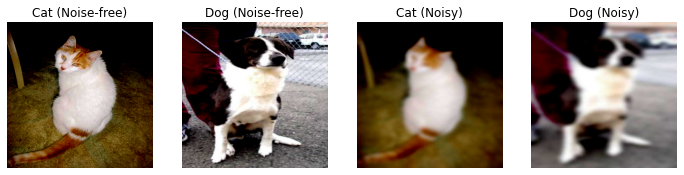

In [ ]:
fig = plt.figure(figsize=(12, 3))
ax=fig.add_subplot(141)
ax.imshow(clear_cat_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Cat (Noise-free)')
ax=fig.add_subplot(142)
ax.imshow(clear_dog_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Dog (Noise-free)')
ax=fig.add_subplot(143)
ax.imshow(noisy_cat_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Cat (Noisy)')
ax=fig.add_subplot(144)
ax.imshow(noisy_dog_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Dog (Noisy)')
plt.show()

# Deep Learning Models of the Ventral Visual Stream

AlexNet and other Deep Convolutional Neural networks are considered to be a good model of the ventral visual stream for visual categorization. Studies have tried to compare different layers of the Deep Neural Networks with the activity in different brain regions. See Below.

<img src="https://www.biorxiv.org/content/biorxiv/early/2020/01/02/407007/F1.large.jpg" width="500" />

Figure from [Schrimpf et al. 2020](https://www.biorxiv.org/content/10.1101/407007v2.full)

Lets try to model the visual categorisation task using AlexNet as model of the ventral visual stream.


## Create Test Neural Network (AlexNet, 2012 with Batch Normalization and a downscaling factor)

We add Batch Normalization to make training faster and add a scaling factor to test the architechture in a relatively smaller and computationally feasible model.
The parameter `downscale` scales down the number of channels in the network by the factor given by the value. For computational feasibility on Google Colab we use an Alexnet downscaled by a factor of 2.

<img src="https://miro.medium.com/max/1838/1*bD_DMBtKwveuzIkQTwjKQQ.png" width="700">

In [ ]:
# Define AlexNet with different modules representing different brain areas
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000, downscale=1):
    """
    Args:
      num_classes: int
      downscale: int
    """
    super(AlexNet, self).__init__()
    self.retina = nn.Sequential(
        nn.Conv2d(3, 64//downscale, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.lgn = nn.Sequential(
        nn.Conv2d(64//downscale, 192//downscale, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.v1 = nn.Sequential(
        nn.Conv2d(192//downscale, 384//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384//downscale),
    )
    self.v2 = nn.Sequential(
        nn.Conv2d(384//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
    )
    self.v4 = nn.Sequential(
        nn.Conv2d(256//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.it = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256//downscale * 6 * 6, 4096//downscale),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096//downscale, 4096//downscale),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(4096//downscale, num_classes)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
    Returns:
      x: torch.Tensor
    """
    x = self.retina(x)
    x = self.lgn(x)
    x = self.v1(x)
    x = self.v2(x)
    x = self.v4(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.it(x)
    x = self.classifier(x)
    return x

# Visualize the Neural Network using TensorBoard

In [ ]:
# Create an neural network object and visualise it with an example image
net = AlexNet(num_classes=2, downscale=2)
writer = SummaryWriter('runs/AlexNet')
writer.add_graph(net, clear_dog_image)
writer.close()

In [ ]:
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

## Training Loop

In [ ]:
# define function for running some epochs of training
def train(num_epochs, train_batch, val_batch,
          training_losses=None, validation_losses=None, device='cpu'): #Training

  net.train()
  if training_losses is None:
    training_losses = []
  if validation_losses is None:
    validation_losses = []
  for epoch in tqdm.tqdm(range(num_epochs)):
    for batch_idx, (data, target) in enumerate(train_batch):
      data = data.to(device).float()
      target = target.to(device).long()
      # reset the parameter gradients
      optimizer.zero_grad()
      # forward pass + backward pass + optimize
      prediction = net(data)
      loss = criterion(prediction, target)
      loss.backward()
      optimizer.step()
      training_losses += [loss.item()]
    for batch_idx, (data, target) in enumerate(val_batch):
      data = data.to(device).float()
      target = target.to(device).long()
      # forward pass only
      prediction = net(data)
      loss = criterion(prediction, target)
      validation_losses += [loss.item()]
  return training_losses, validation_losses

## Accuracy Calculation

In [ ]:
# define function to calculate current accuracy with a given dataloader
def accuracy(dataloader, device='cpu'): #Get the accuracies
  net.eval()
  correct = 0
  count = 0
  for data, target in tqdm.tqdm(dataloader):
    data = data.to(device).float()
    target = target.to(device).long()

    prediction = net(data)
    _, predicted = torch.max(prediction, 1)
    count += target.size(0)
    correct += (predicted == target).sum().item()

  acc = 100 * correct / count
  return count, acc


# define function to evaluate and print training and test accuracy
def evaluate(net, device='cpu', title=""):
  net.eval()
  train_count, train_acc = accuracy(clear_train_batches, device=device)
  test_count, test_acc = accuracy(clear_test_batches, device=device)
  print(f'Accuracy on the {train_count} clear training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} clear testing samples {title}: {test_acc:0.2f}')
  train_count, train_acc = accuracy(noisy_train_batches, device=device)
  test_count, test_acc = accuracy(noisy_test_batches, device=device)
  print(f'Accuracy on the {train_count} blurry training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} blurry testing samples {title}: {test_acc:0.2f}')

## Hypothesis:
$H_0$: The visual system model with experience of seeing images without blur will have a much better performance on the blurry images out of the box compared to the naive learner.

$H_1$: The visual system model with experience of seeing images without blur will have a better performance on the blurry images after training compared to the naive learner.

# Naive Learner

A naive learner model looks at only the blurry images and tries to learn the difference between a cat and a dog 

*Warning: Training takes approximately 2-3 minutes per epoch so choose the number of epochs with that in mind. Here the we run only one epoch as an example, try running 5-10 epochs for good performance.*

  0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples before training: 50.00
Accuracy on the 2494 clear testing samples before training: 50.00


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples before training: 50.00
Accuracy on the 2494 blurry testing samples before training: 50.00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples after training: 62.22
Accuracy on the 2494 clear testing samples after training: 61.83


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples after training: 72.82
Accuracy on the 2494 blurry testing samples after training: 72.21


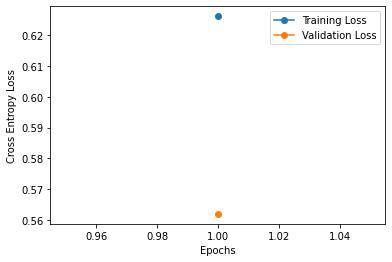

In [ ]:
# Define network, loss function and optimizer
net = AlexNet(num_classes=2, downscale=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
net.to(DEVICE)

# Evaluate before training
evaluate(net, device=DEVICE, title="before training")

# Define number of epochs
num_pretraining_epochs = 0
num_training_epochs = 1
num_epochs = num_pretraining_epochs + num_training_epochs

# Save network weights
torch.save(net.state_dict(), "naive_before_training")

# Training loop
naive_training_losses, naive_validation_losses = train(num_training_epochs,
                                                       noisy_train_batches,
                                                       noisy_val_batches,
                                                       device=DEVICE)

# Save network weights
torch.save(net.state_dict(), "naive_after_training")

# Evaluate after training
evaluate(net, device=DEVICE, title="after training")

# Plot Loss over epochs
plt.figure()
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(naive_training_losses,
                                             num_training_epochs)],
         "o-", label="Training Loss")
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(naive_validation_losses,
                                             num_training_epochs)],
         "o-", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

# Expert Experienced Learner

A expert learner model first learns to look at less noisy images of cats and dogs and then try to distinguish the blurry images. It then learns on blurry images and tries to understand the difference between a cat and a dog 

*Warning: Pretraining takes approximately 5-6 minutes and Training takes 2-3 minutes per epoch so choose the number of epochs with that in mind.Here the we run only one epoch as an example, try running 5-10 epochs for both pretraining and training for good performance.*

  0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples before training: 50.00
Accuracy on the 2494 clear testing samples before training: 50.00


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples before training: 50.00
Accuracy on the 2494 blurry testing samples before training: 50.00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples after pretraining: 75.61
Accuracy on the 2494 clear testing samples after pretraining: 75.30


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples after pretraining: 56.33
Accuracy on the 2494 blurry testing samples after pretraining: 56.62


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples after training: 72.68
Accuracy on the 2494 clear testing samples after training: 72.13


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples after training: 76.21
Accuracy on the 2494 blurry testing samples after training: 75.82


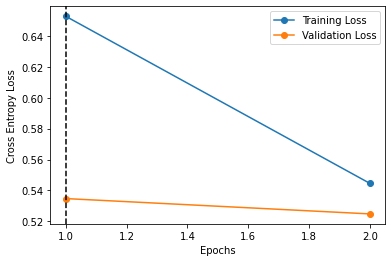

In [ ]:
# Define network, loss function and optimizer
net = AlexNet(num_classes=2,downscale=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
net.to(DEVICE)

# Evaluate before pretraining
evaluate(net, device=DEVICE, title="before training")

# Define number of epochs
num_pretraining_epochs = 1
num_training_epochs = 1
num_epochs = num_pretraining_epochs + num_training_epochs

# Save network weights
torch.save(net.state_dict(), "expert_before_training")

# Pretraining loop
training_losses, validation_losses = train(num_pretraining_epochs,
                                           clear_train_batches,
                                           clear_val_batches,
                                           device=DEVICE)

# Evaluate after pretraining
evaluate(net, device=DEVICE, title="after pretraining")

# Save network weights
torch.save(net.state_dict(), "expert_after_pretraining")

# Training loop
experienced_training_losses, experienced_validation_losses = train(num_training_epochs,
                                                                   noisy_train_batches,
                                                                   noisy_val_batches,
                                                                   training_losses=training_losses,
                                                                   validation_losses=validation_losses,
                                                                   device=DEVICE)

# Save network weights
torch.save(net.state_dict(), "expert_after_training")

# Evaluate after training
evaluate(net, device=DEVICE, title="after training")

# Plot Loss over epochs
plt.figure()
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(experienced_training_losses,
                                             num_epochs)],
         "o-", label="Training Loss")
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(experienced_validation_losses,
                                             num_epochs)],
         "o-", label="Validation Loss")
plt.axvline(num_pretraining_epochs, linestyle='dashed', color='k')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

Wow thats interesting! The model of the visual system has a hard time to distinguish between blurry cats and dogs even after having seen images of cats and dog before! It takes further training on the blurry images to be able to learn the difference well. Even then, it is only a little better than the naive model. Would it be same for a human being?

Now, if you want to understand thats happening during training and pretraining, is there a way to visualise the effect of on the network itself? Yes!! You can look at either how: 

1.   Convolution kernels, OR
2.   Average output of Intermediate layers

have changed over pretraining and training to try and understand how the networks learns to look for more specific features.

## Looking at Convolution Kernels

In [ ]:
# @title Helper Function to plot the 16 filters of the first layer
def plot_filter(net, title=""):
  layer = 0
  with torch.no_grad():
    params = list(net.parameters())
    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    filters = []
    for filter_index in range(min(16, params[layer].shape[0])):
      row_index = filter_index // 4
      col_index = filter_index % 4

      filter = params[layer][filter_index, :, :, :]
      filter_image = filter.permute((1,2,0))
      scale = np.abs(filter_image).max()
      scaled_image = filter_image / (2 * scale) + 0.5
      filters.append(scaled_image)
      axs[row_index, col_index].imshow(scaled_image)
      axs[row_index, col_index].axis('off')
    plt.suptitle(title)
    plt.show()

### Naive Model

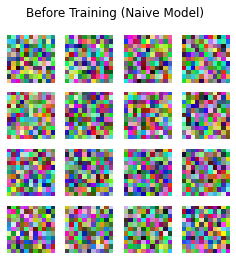

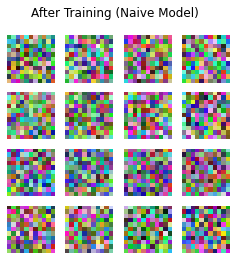

In [ ]:
net = AlexNet(num_classes=2, downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('naive_before_training'))
plot_filter(net, "Before Training (Naive Model)")

net = AlexNet(num_classes=2, downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('naive_after_training'))
plot_filter(net, "After Training (Naive Model)")

### Expert Experienced Model

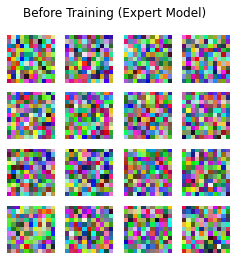

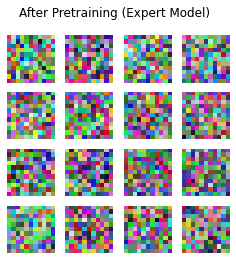

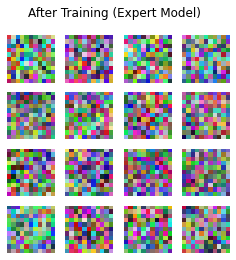

In [ ]:
net = AlexNet(num_classes=2, downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('expert_before_training'))
plot_filter(net, "Before Training (Expert Model)")

net = AlexNet(num_classes=2, downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('expert_after_pretraining'))
plot_filter(net, "After Pretraining (Expert Model)")

net = AlexNet(num_classes=2, downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('expert_after_training'))
plot_filter(net, "After Training (Expert Model)")

Looks like with the small amount of training, the filters are not very meaningful. Also, there seem to be only very small differences are visible at the first layer.

## Looking at Intermediate Layer Output

In [ ]:
# choose intermidiate layers from which to get the output
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'v1': 'v1',
      'v2': 'v2',
      'v4': 'v4',
  }

In [ ]:
# @title Helper functions to get and plot intermediate layer output

def plot_intermediate_layers(image, net, return_layers=return_layers):
  # Get output for the image from the intermediate layers
  intermediate_output = LayerGetter(net, return_layers=return_layers)(image)
  fig = plt.figure(figsize=(12, 3))
  ax=fig.add_subplot(141)
  ax.imshow(image.squeeze(0).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Original Image')
  ax=fig.add_subplot(142)
  ax.imshow(intermediate_output[0]['v1'].detach().cpu().squeeze(0).mean(axis=0))
  plt.axis('off')
  plt.title('V1 layer (Average)')
  ax=fig.add_subplot(143)
  ax.imshow(intermediate_output[0]['v2'].detach().cpu().squeeze(0).mean(axis=0))
  plt.axis('off')
  plt.title('V2 layer (Average)')
  ax=fig.add_subplot(144)
  ax.imshow(intermediate_output[0]['v4'].detach().cpu().squeeze(0).mean(axis=0))
  plt.axis('off')
  plt.title('V4 layer (Average)')
  plt.show()

### Naive Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Naive Model
Before Training


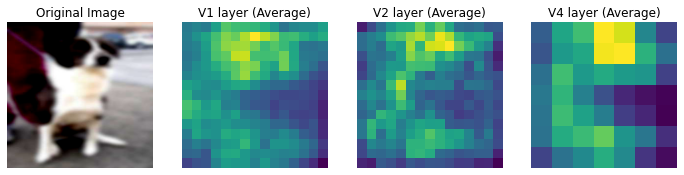

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


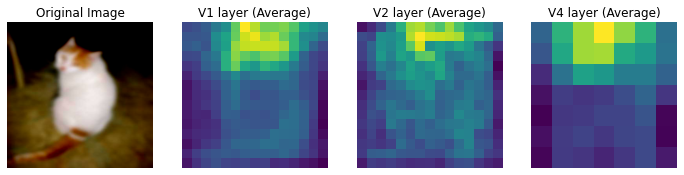

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After Training


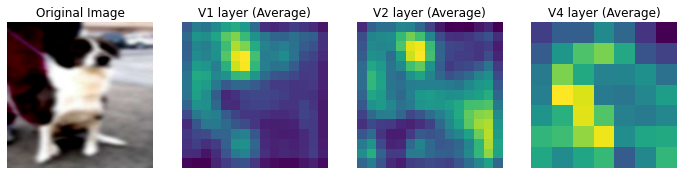

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


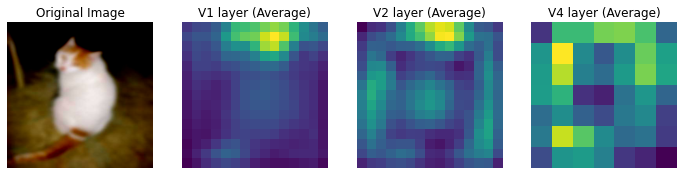

In [ ]:
print("Naive Model\n=============")
print("Before Training")
net = AlexNet(num_classes=2, downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('naive_before_training'))
plot_intermediate_layers(noisy_dog_image, net)
plot_intermediate_layers(noisy_cat_image, net)

print("After Training")
net = AlexNet(num_classes=2, downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('naive_after_training'))
plot_intermediate_layers(noisy_dog_image, net)
plot_intermediate_layers(noisy_cat_image, net)

Over training, the naive model seems to have learnt more complex features as apparent from the intermediate layer outputs.

### Expert Experienced Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Expert Model
Before Training


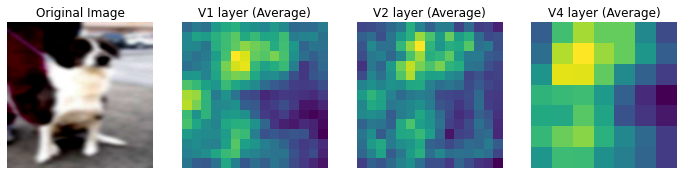

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


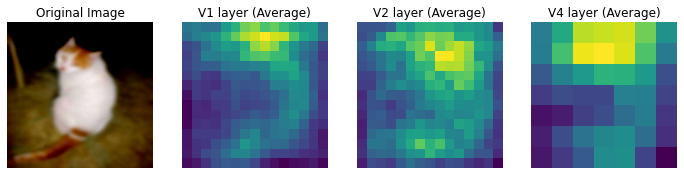

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After Pretraining


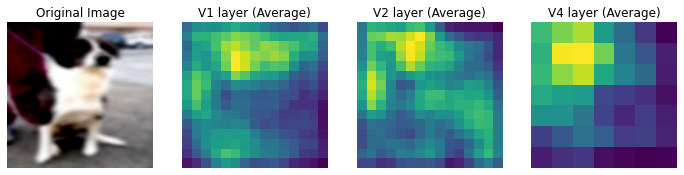

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


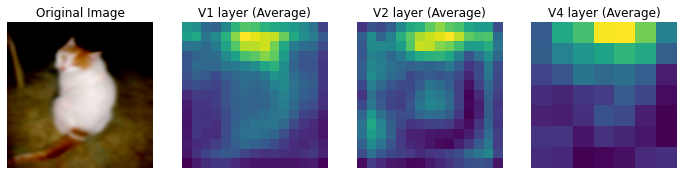

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After Training


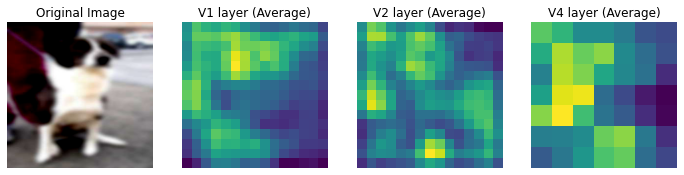

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


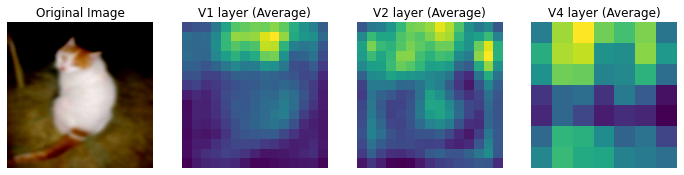

In [ ]:
print("Expert Model\n=============")
print("Before Training")
net = AlexNet(num_classes=2,downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('expert_before_training'))
plot_intermediate_layers(noisy_dog_image,net)
plot_intermediate_layers(noisy_cat_image,net)

print("After Pretraining")
net = AlexNet(num_classes=2,downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('expert_after_pretraining'))
plot_intermediate_layers(noisy_dog_image,net)
plot_intermediate_layers(noisy_cat_image,net)

print("After Training")
net = AlexNet(num_classes=2,downscale=2)
# Load and assign previous state
net.load_state_dict(torch.load('expert_after_training'))
plot_intermediate_layers(noisy_dog_image,net)
plot_intermediate_layers(noisy_cat_image,net)

Clearly, the network output is only somewhat similar between pretraining and training. The differences seem to suggest that the process of learning over blurred images did change the features the network focused which probably contibuted to improved response to blurry images.

In [ ]:
# @markdown If you wish to generate cat and dog images with other degrees of blur or different type of noise
# @markdown refer to this cell which contains the code for dataset cleaning and filtering the original dataset.
# @markdown Feel free to uncomment and change the code to generate other variations of the dataset.

# @markdown *Note: The dataset generation process can take a while to run.*


# # Download the Data
# if "cats-and-dogs.zip" not in os.listdir():
#   !wget --no-check-certificate \
#     "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#     -O "cats-and-dogs.zip"

# local_zip = 'cats-and-dogs.zip'
# zip_ref   = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall()
# zip_ref.close()

# cat_folder = "PetImages/Cat/"
# dog_folder = "PetImages/Dog/"

# def check_file(file):
#   try:
#     im = Image.open(file).convert('RGB')
#     #im = im.filter(ImageFilter.BLUR)
#     return True
#   except:
#     return False

# cat_files = list(filter(check_file, [cat_folder+i for i in os.listdir(cat_folder)]))
# dog_files = list(filter(check_file, [dog_folder+i for i in os.listdir(dog_folder)]))
# np.random.shuffle(cat_files)
# np.random.shuffle(dog_files)

# # Train test split
# test_ratio = 0.1
# # assert len(cat_files) == len(dog_files)
# N = min(len(cat_files),len(dog_files))

# training_length = int((1-test_ratio)*N)
# train_indices = np.arange(training_length)
# test_indices = np.arange(training_length,N)

# # Create data directory
# try:
#   os.mkdir("dataset")
#   os.mkdir("dataset/train/")
#   os.mkdir("dataset/test/")
#   os.mkdir("dataset/train/cat/")
#   os.mkdir("dataset/train/dog/")
#   os.mkdir("dataset/test/cat/")
#   os.mkdir("dataset/test/dog/")
#   os.mkdir("dataset_blur_5")
#   os.mkdir("dataset_blur_5/train/")
#   os.mkdir("dataset_blur_5/test/")
#   os.mkdir("dataset_blur_5/train/cat/")
#   os.mkdir("dataset_blur_5/train/dog/")
#   os.mkdir("dataset_blur_5/test/cat/")
#   os.mkdir("dataset_blur_5/test/dog/")
#   os.mkdir("dataset_blur_2")
#   os.mkdir("dataset_blur_2/train/")
#   os.mkdir("dataset_blur_2/test/")
#   os.mkdir("dataset_blur_2/train/cat/")
#   os.mkdir("dataset_blur_2/train/dog/")
#   os.mkdir("dataset_blur_2/test/cat/")
#   os.mkdir("dataset_blur_2/test/dog/")
# except:
#   pass

# for i in tqdm.tqdm(range(training_length)):
#   target = f"dataset/train/cat/{i+1}.jpg"
#   copyfile(cat_files[i],target)
#   target = f"dataset/train/dog/{i+1}.jpg"
#   copyfile(dog_files[i],target)
#   target = f"dataset_blur_2/train/cat/{i+1}.jpg"
#   im = Image.open(cat_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 2))
#   im.save(target)
#   target = f"dataset_blur_2/train/dog/{i+1}.jpg"
#   im = Image.open(dog_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 2))
#   im.save(target)
#   target = f"dataset_blur_5/train/cat/{i+1}.jpg"
#   im = Image.open(cat_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 5))
#   im.save(target)
#   target = f"dataset_blur_5/train/dog/{i+1}.jpg"
#   im = Image.open(dog_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 5))
#   im.save(target)

# for i in tqdm.tqdm(range(training_length,N)):
#   target = f"dataset/test/cat/{int(i-training_length+1)}.jpg"
#   copyfile(cat_files[i],target)
#   target = f"dataset/test/dog/{int(i-training_length+1)}.jpg"
#   copyfile(dog_files[i],target)
#   target = f"dataset_blur_2/test/cat/{int(i-training_length+1)}.jpg"
#   im = Image.open(cat_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 2))
#   im.save(target)
#   target = f"dataset_blur_2/test/dog/{int(i-training_length+1)}.jpg"
#   im = Image.open(dog_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 2))
#   im.save(target)
#   target = f"dataset_blur_5/test/cat/{int(i-training_length+1)}.jpg"
#   im = Image.open(cat_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 5))
#   im.save(target)
#   target = f"dataset_blur_5/test/dog/{int(i-training_length+1)}.jpg"
#   im = Image.open(dog_files[i]).convert('RGB')
#   im = im.filter(ImageFilter.GaussianBlur(radius = 5))
#   im.save(target)

# rmtree("PetImages")

# def zipdir(path, ziph):
#     # ziph is zipfile handle
#     for root, dirs, files in os.walk(path):
#         for file in files:
#             ziph.write(os.path.join(root, file),
#                        os.path.relpath(os.path.join(root, file),
#                                        os.path.join(path, '..')))

# zipf = zipfile.ZipFile('catvdog_clear.zip', 'w', zipfile.ZIP_DEFLATED)
# zipdir('dataset/', zipf)
# zipf.close()
# zipf = zipfile.ZipFile('catvdog_blur_2.zip', 'w', zipfile.ZIP_DEFLATED)
# zipdir('dataset_blur_2/', zipf)
# zipf.close()
# zipf = zipfile.ZipFile('catvdog_blur_5.zip', 'w', zipfile.ZIP_DEFLATED)
# zipdir('dataset_blur_5/', zipf)
# zipf.close()